In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Import Libraries***

In [3]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

***Load Training and Testing Brain Tumour Images***

In [4]:
train_path = '/content/drive/MyDrive/MSC Project/Brain Tumor MRI Dataset/Training_project'
test_path = '/content/drive/MyDrive/MSC Project/Brain Tumor MRI Dataset/Testing_project'

***Count the number of MRI Images in the training and testing set***

In [5]:
def get_number(path):
  if not os.path.exists(path):
    return 0
  count = 0

  for current_path, dirs, files in os.walk(path):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr + "/*")))
  return count

In [6]:
training_images = get_number(train_path)
testing_images = get_number(test_path)
num_classes = len(glob.glob(train_path + "/*"))

print("Number of classes is", num_classes)
print("Number of training samples is", training_images)
print("Number of testing samples is", testing_images)

Number of classes is 4
Number of training samples is 5752
Number of testing samples is 1311


***Data Augmentation***

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )

In [8]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    shuffle = False,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 5752 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


***Create MobileNet Transfer Learning Model***

In [9]:
# Load pre-trained MobileNet model without the top classification layers
base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add more trainable layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)  # Additional dense layer
x = Dense(256, activation='relu')(x)  # Additional dense layer
predictions = Dense(4, activation='softmax')(x)  # Four classes: no_tumour, pituitary_tumour, meningioma_tumour, glioma_tumour

In [10]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,935,620 (18.83 MB)

 Trainable params: 1,706,756 (6.51 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [12]:
best_model_path = '//content/drive/MyDrive/MSC Project/best_model_MobileNet.keras'

# Early stopping callback
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True, verbose = 1)

# Model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint(best_model_path, monitor = 'val_accuracy', save_best_only = True, verbose = 1)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint]  # Pass both callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7140 - loss: 0.7099
Epoch 1: val_accuracy improved from -inf to 0.87344, saving model to //content/drive/MyDrive/MSC Project/best_model_MobileNet.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1246s 7s/step - accuracy: 0.7146 - loss: 0.7087 - val_accuracy: 0.8734 - val_loss: 0.3328
Epoch 2/100
  1/179 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9062 - loss: 0.2392

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.87344 to 0.96774, saving model to //content/drive/MyDrive/MSC Project/best_model_MobileNet.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9062 - loss: 0.2392 - val_accuracy: 0.9677 - val_loss: 0.1063
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9048 - loss: 0.2641
Epoch 3: val_accuracy did not improve from 0.96774
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 496ms/step - accuracy: 0.9048 - loss: 0.2641 - val_accuracy: 0.8984 - val_loss: 0.2538
Epoch 4/100
  1/179 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8438 - loss: 0.2993
Epoch 4: val_accuracy did not improve from 0.96774
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.8438 - loss: 0.2993 - val_accuracy: 0.9677 - val_loss: 0.1213
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9125 - loss: 0.2350
Epoch 5: val_accuracy did not improve from 0.96774
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 498ms/step - accuracy: 0.9125 - loss: 0.2349 - val_ac

In [14]:
# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

In [15]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.8383 - loss: 0.4180
Test Accuracy: 0.8764302134513855


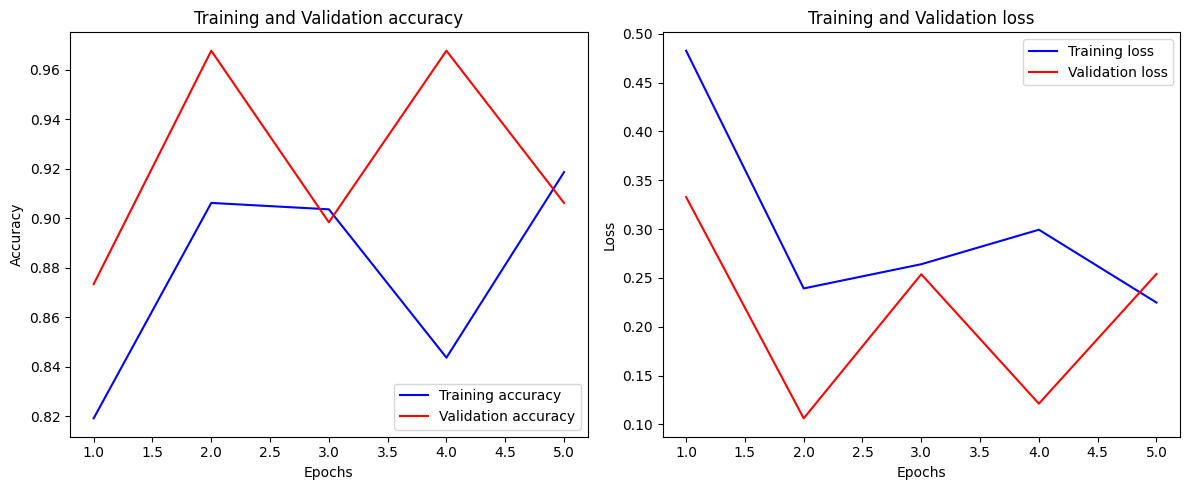

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation loss
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust the layout for better appearance
plt.show()

In [17]:
Classes = ['Glioma', 'Meningioma', 'No Tumour', 'Pituitary']

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = model.predict(test_generator, testing_images//batch_size+1,verbose=1,).argmax(axis=1)
#print(y_test)
print(pred)
#Classification report of every label
print(classification_report(y_test, pred, target_names = Classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step
[0 0 0 ... 3 3 3]
              precision    recall  f1-score   support

      Glioma       0.90      0.86      0.88       300
  Meningioma       0.83      0.67      0.74       306
   No Tumour       0.90      0.96      0.93       405
   Pituitary       0.86      0.99      0.92       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.87      0.88      0.87      1311



In [19]:
correct = 0
incorrect = 0
for i in range(len(y_test)):

    #print("Test Sample is: ", y_test[i], "while predicted sample is: ", pred[i])

    if y_test[i] != pred[i]:
        incorrect += 1
    else:
        correct += 1

print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

Total number of test cases 1311
Number of correct predictions 1149
Number of incorrect predictions 162


***Plot Confusion Matrix***

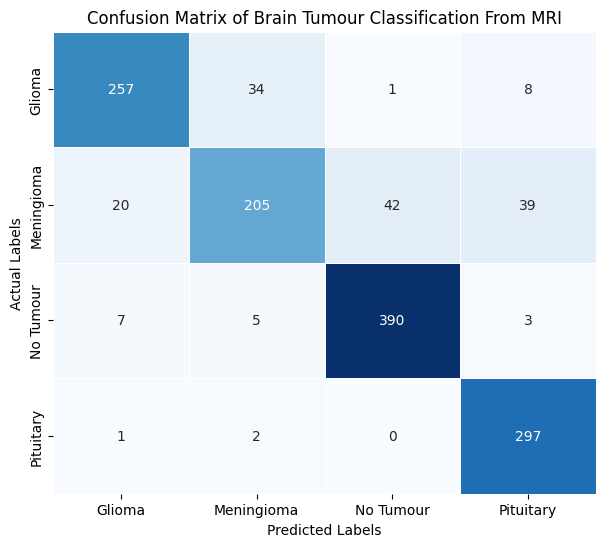

In [20]:
import pandas as pd
import seaborn as sn

# Create a confusion matrix
conf_mat = confusion_matrix(y_test, pred)

# Create a DataFrame from the confusion matrix
conf_df = pd.DataFrame(conf_mat, columns = Classes, index = Classes)

# Plot the confusion matrix using seaborn with annotated actual and predicted labels
plt.figure(figsize = (7, 6))
plt.title('Confusion Matrix of Brain Tumour Classification From MRI')
sn.heatmap(conf_df, fmt = "d", cmap = "Blues", annot = True, cbar = False, linewidths = .5)

# Add x and y axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.show()